In [4]:
#Итак, что нужно сделать: у нас есть данные А/А-теста с '2023-08-22' по '2023-08-28'. 
#Вам нужно сделать симуляцию, как будто мы провели 10000 А/А-тестов. 
#На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. 
#Провести сравнение этих подвыборок t-testом.

#1. Построить гистограмму распределения получившихся 10000 p-values.

#2. Посчитать, какой процент p values оказался меньше либо равен 0.05

#3. Написать вывод по проведенному А/А-тесту, корректно ли работает наша система сплитования.

#4. Пришлите ссылку на merge request c проведенным анализом.

In [5]:
#Проведем А/А-тесты для сравниния выбранного показателя(CTR) в тестовой и контрольной группы.

In [6]:
# Импортируем необходимые библиотеки
import pandas as pd
import pandahouse as ph
import seaborn as sns
import scipy.stats as stats
import hashlib
import swifter
import numpy as np
import matplotlib.pyplot as plt

In [7]:
#параметры соединения - нужны, чтобы подключиться к нужной схеме данных
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20230920',
'user':'student',
'password':'dpo_python_2020'
}

In [8]:
#текст запроса
query = '''
SELECT user_id,
    case when exp_group = 2 then 0 else 1 end as exp_index,
    countIf(action = 'like') / countIf(action = 'view')  as ctr
FROM simulator_20230920.feed_actions 
WHERE toDate(time) BETWEEN '2023-08-22' AND '2023-08-28' AND exp_group IN (2,3)
GROUP BY user_id,exp_group 
'''

# эта функция выполнит запрос и запишет его результат в pandas DataFrame
df_aa = ph.read_clickhouse(query, connection=connection)

In [9]:
#Посмотрим первые 5 результатов датасета
df_aa.head() 

,user_id,exp_index,ctr
0,115383,1,0.153226
1,10326,1,0.181818
2,123580,1,0.204918
3,131473,0,0.193878
4,23985,0,0.272727


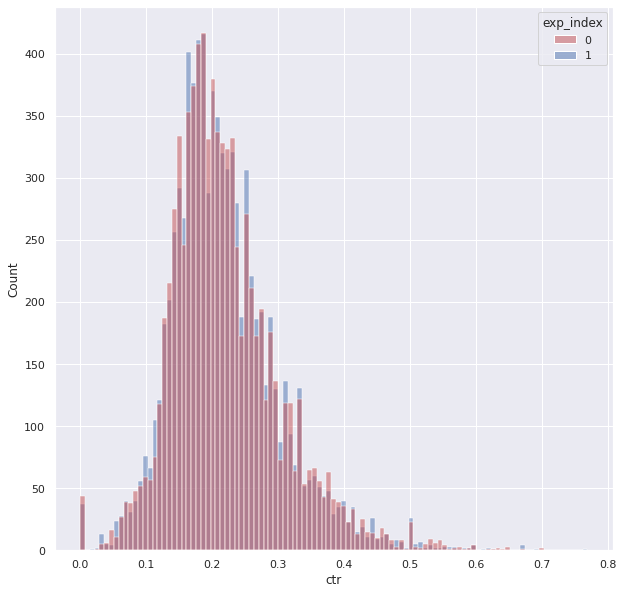

In [11]:
#Визуализируем графики CTR тестовой и контрольной группы
sns.set(rc={'figure.figsize':(10,10)})

sns.histplot(data = df_aa, 
              x='ctr', 
              hue='exp_index', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)
plt.show()

In [74]:
#Распределения похожи на нормальные и имеют схожие среднии значения

In [71]:
#Проведем Т-тест Стьюдента на целой выборки аггригированные по нашим группам
stats.ttest_ind(df_aa[df_aa.exp_index == 0].ctr,
                df_aa[df_aa.exp_index == 1].ctr,
                alternative='two-sided')

Ttest_indResult(statistic=0.661767574315154, pvalue=0.5081292746070931)

In [75]:
#группы являются статистически эквивалентными

In [73]:
#Зададим переменные: Нам надо сделать выборки из каждой группы по 500 пользователей
#и определить p-value в тесте Стьюдента 10 000 раз для неповторяющихся выборокиз этих групп.
sample_size=500
num_tests=10000

In [76]:
# Создадим общую функцию для случайной выборки пользователей из группы
def random_samples_of_group(exp_index):
    return df_aa[df_aa.exp_index == exp_index].ctr.sample(sample_size)
    

In [35]:
#Создадим массив со значениями p-value для 10 000 тестов Стьюдента
t_tests=pd.DataFrame([(stats.ttest_ind(random_samples_of_group(0),
                random_samples_of_group(1),
                alternative='two-sided')[1]) for i in range(0,num_tests)])

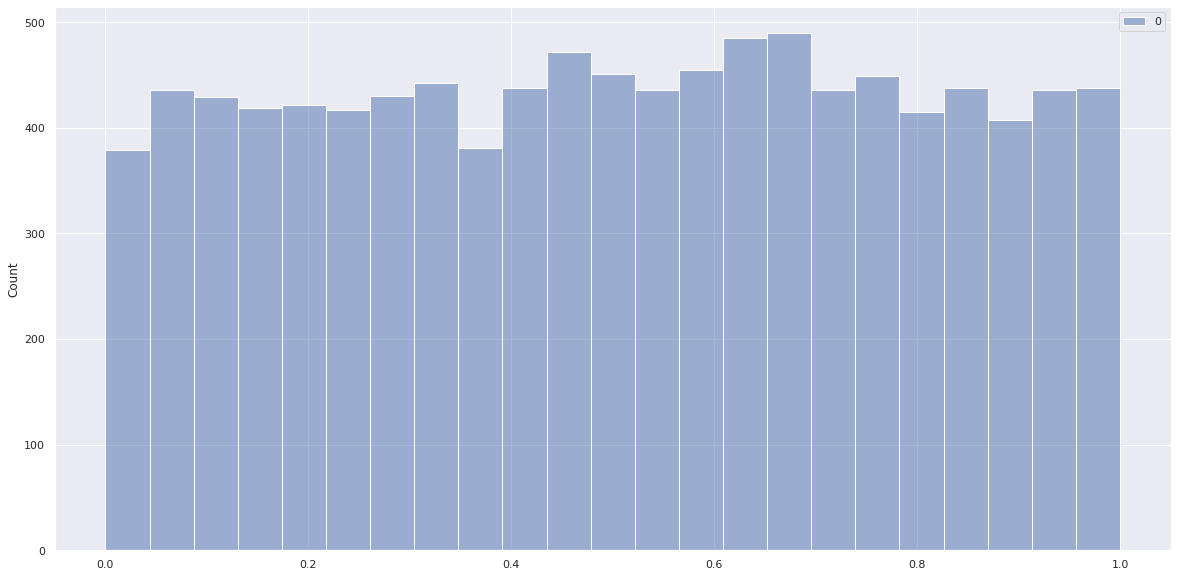

In [41]:
#Визуализируем этот массив на гистограмме
sns.set(rc={'figure.figsize':(20,10)})
sns.histplot(data = t_tests,kde=False)
plt.show()

In [63]:
#Определим какой процент результатов в массиве имеет значение <=0.05
print(str(((t_tests.values<=0.05).sum()/num_tests)*100) +' %')

4.45 %


In [64]:
#процент результатов меньше\равно 0.05 меньше 5% что дает право говорить что система сплитования работает корректно

In [70]:
#Общий вывод:
#При проведении 10 000 А\А тестов выборок по 500 случайных пользователей в статистически эквивалентных группах выяснилось, 
#что система сплитования работает корректно тк. процент результатов где p-value меньше 0,05 меньше 5 процентов.